In [1]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]


In [2]:
nibabel>=3.0.1
scikit-learn>=0.21.0
nilearn>=0.6.0
pandas>=1.1.0
numpy<1.24
seaborn>=0.7.0
matplotlib>=2.2.0
scipy>=1.7.0
pynv
joblib>=0.15
h5py

SyntaxError: invalid syntax (837246186.py, line 1)

In [5]:
!pip install datalad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 30.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
import datalad.api as dl
import warnings
import nibabel as nib
warnings.simplefilter('ignore')

In [4]:
import os
import nibabel as nib
import pandas as pd

def load_isc_data(base_path):
    """
    Load ISC data from the specified folder structure.

    Parameters
    ----------
    base_path : str
        The base directory containing the subfolders with ISC data.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the loaded data with columns:
        'folder', 'subject', 'file_path', and 'data'.
    """
    # Initialize a list to store metadata and data
    data_list = []


    # Iterate through folders in the base path
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):  # Ensure it's a folder
            # Iterate through files in each folder
            for file in os.listdir(folder_path):
                if file.endswith('.nii.gz'):  # Check for .nii.gz files
                    file_path = os.path.join(folder_path, file)
                    subject = file.split('_')[0]  # Extract subject from filename
                    
                    # Append metadata and data to the list
                    data_list.append({
                        'condition': folder,
                        'subject': subject,
                        'file_path': file_path,
    
                    })
    
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(data_list)
    return df

# Example usage
base_path = "/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub"
isc_data_df = load_isc_data(base_path)
subjects = isc_data_df.uniq
isc_data_df = isc_data_df.sort_values(by='subject')
# Display the DataFrame
print(isc_data_df.head())


   condition subject                                          file_path
0      N_ANA  sub-07  /data/rainville/dSutterlin/projects/ISC_hypnot...
3      HYPER  sub-07  /data/rainville/dSutterlin/projects/ISC_hypnot...
6    N_HYPER  sub-07  /data/rainville/dSutterlin/projects/ISC_hypnot...
10       ANA  sub-07  /data/rainville/dSutterlin/projects/ISC_hypnot...
1      N_ANA  sub-38  /data/rainville/dSutterlin/projects/ISC_hypnot...


In [8]:

subjects = isc_data_df['subject'].unique()
print("Subjects:", subjects)

condition_order = sorted(isc_data_df['condition'].unique())
subject_file_dict = {}

for subject in subjects:
    # Filter DataFrame for the specific subject
    subject_data = isc_data_df[isc_data_df['subject'] == subject]
    # Ensure file paths are sorted by condition order
    subject_data = subject_data.set_index('condition').loc[condition_order]
    subject_file_dict[subject] = subject_data['file_path'].tolist()

# Verify the dictionary
for sub, paths in subject_file_dict.items():
    print(f"Subject: {sub}, Files: {paths}")


Subjects: ['sub-07' 'sub-38' 'sub-42']
Subject: sub-07, Files: ['/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/ANA/sub-07_87-vol_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/HYPER/sub-07_84-vol_HYPER.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/N_ANA/sub-07_110-vol_N_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/N_HYPER/sub-07_110-vol_N_HYPER.nii.gz']
Subject: sub-38, Files: ['/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/ANA/sub-38_87-vol_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/HYPER/sub-38_84-vol_HYPER.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/N_ANA/sub-38_110-vol_N_ANA.nii.gz', '/

Load data

**Probabilistic atlas**

In [4]:
atlas_path = '/data/rainville/dSutterlin/projects/isc_suggestions/DiFuMo256/3mm/maps.nii.gz'
atlas_dict_path = '/data/rainville/dSutterlin/projects/isc_suggestions/DiFuMo256/labels_256_dictionary.csv'
atlas = nib.load(atlas_path)
atlas_df = pd.read_csv(atlas_dict_path)
print('atlas loaded with N ROI : ', atlas.shape)

atlas loaded with N ROI :  (104, 123, 104, 256)


In [6]:
mask

nltools.data.brain_data.Brain_Data(data=(238955,), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

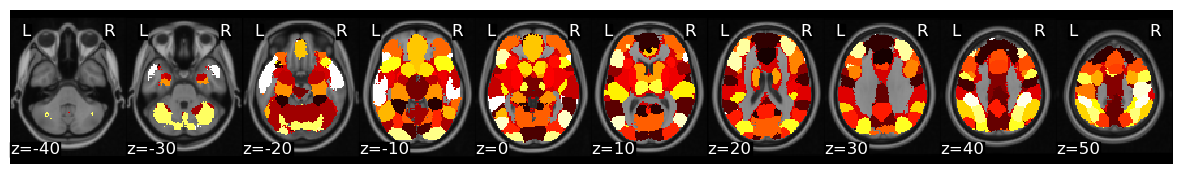

In [5]:
mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')
mask_x = expand_mask(mask)
mask.plot()

In [6]:
mask_nifti = mask_x.to_nifti()
print(mask_x.shape, mask_nifti.shape)

<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(50, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)> (91, 109, 91, 50)


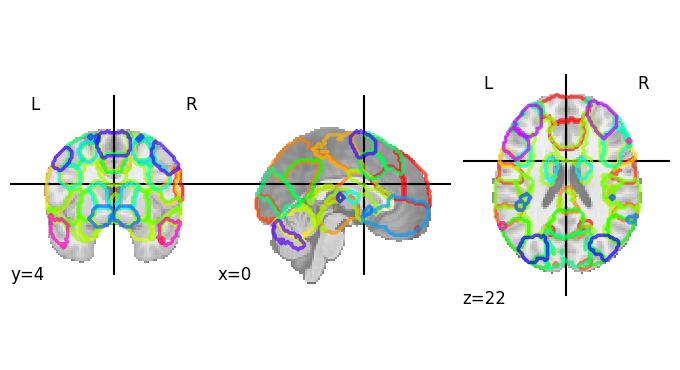

In [34]:
from nilearn.plotting import plot_prob_atlas

mask_nifti = mask_x.to_nifti()
view = plot_prob_atlas(mask_nifti, threshold=None)  # Use threshold=None to display the whole mask
view

**Extract data in ROI**

In [ ]:
isc_data_df[

In [9]:
subject_file_dict.items()

dict_items([('sub-07', ['/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/ANA/sub-07_87-vol_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/HYPER/sub-07_84-vol_HYPER.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/N_ANA/sub-07_110-vol_N_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/N_HYPER/sub-07_110-vol_N_HYPER.nii.gz']), ('sub-38', ['/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/ANA/sub-38_87-vol_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/HYPER/sub-38_84-vol_HYPER.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/test_data_sugg_3sub/N_ANA/sub-38_110-vol_N_ANA.nii.gz', '/data/rainville/dSutterlin/projects/ISC_hypnotic_sug

In [11]:
#func_ana = Brain_Data(ana_files)
n_subj = 6; # limit computation time

roi = 4
roi_mask = mask_x[roi]

#file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*nii.gz'))
ana_data = []
for count, (sub, f) in enumerate(subject_file_dict.items()):
    if count > n_subj:
        break
    else:    
        print(sub)
        data = Brain_Data(f)
        ana_data.append(data.apply_mask(roi_mask))

sub-07
sub-38
sub-42


In [12]:
ana_data

[nltools.data.brain_data.Brain_Data(data=(391, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(391, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(391, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)]

**Hyper align**

In [11]:
ana_data

[nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)]

In [12]:
hyperalign = align(ana_data[:6], method='procrustes')

In [34]:
hyperalign

{'transformed': [nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)],
 'common_model': nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 'transformation_matrix': [nltools.data.brain_data.Brain_Data(data=(2786, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain

Text(0.5, 1.0, 'Aligned Voxel ISC: r=0.3')

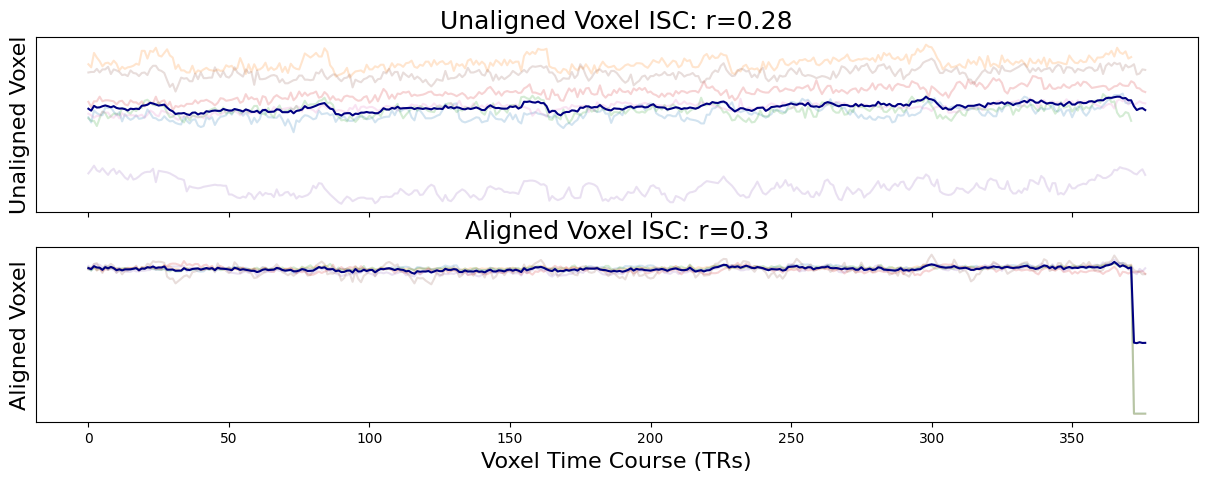

In [17]:
voxel_index = 50

voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in ana_data]).T # x is subject i
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)


**ISC distribution : N voxel pair-wise correlation, meaned**

Unaligned voxel ISC

In [22]:
ana_data[0].data.flatten().shape

(1036392,)

In [23]:
ana_data[0].data.shape[1]

2786

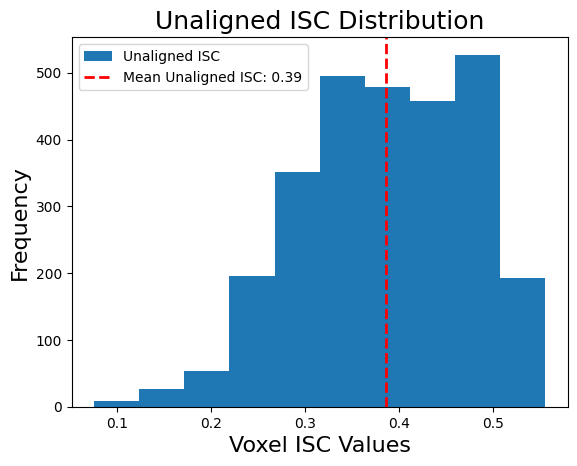

Mean Unaligned ISC (voxel-wise): 0.39


In [30]:
import numpy as np
from nltools.data import Adjacency

unaligned_isc = {}

#compute mean ISC for each unaligned voxel to plot distribution
for voxel_index in range(ana_data[0].data.shape[1]):  # Assuming all_data is a list of Brain_Data objects
    # Extract the time series for this voxel across all subjects
    voxel_time_series = np.array([x.data[:372, voxel_index] for x in ana_data])  # shape (n_subjects, n_timepoints)
    voxel_corr = np.corrcoef(voxel_time_series)  # matrix shape (n_subjects, n_subjects)
    triu_indices = np.triu_indices_from(voxel_corr, k=1) # mean of triangle
    unaligned_isc[voxel_index] = voxel_corr[triu_indices].mean()

plt.hist(unaligned_isc.values(),label='Unaligned ISC')
plt.axvline(x=np.mean(list(unaligned_isc.values())), linestyle='--', color='red', linewidth=2, label=f'Mean Unaligned ISC: {np.mean(list(unaligned_isc.values())):.2f}')
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Unaligned ISC Distribution', fontsize=18)
plt.legend()
plt.show()

# Print the mean ISC value for unaligned data
print(f"Mean Unaligned ISC (voxel-wise): {np.mean(list(unaligned_isc.values())):.2f}")


Mean ISC: 0.33


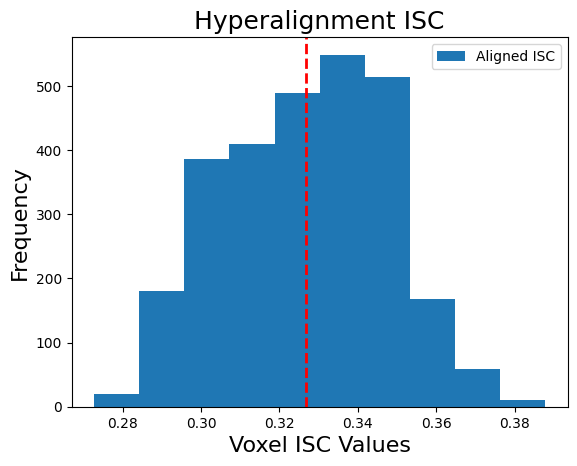

In [32]:
plt.hist(hyperalign['isc'].values(), label='Aligned ISC')
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.legend()
plt.title('Hyperalignment ISC', fontsize=18)

print(f"Mean ISC: {np.mean(list(hyperalign['isc'].values())):.2}")

**Compare a slice of ROI**

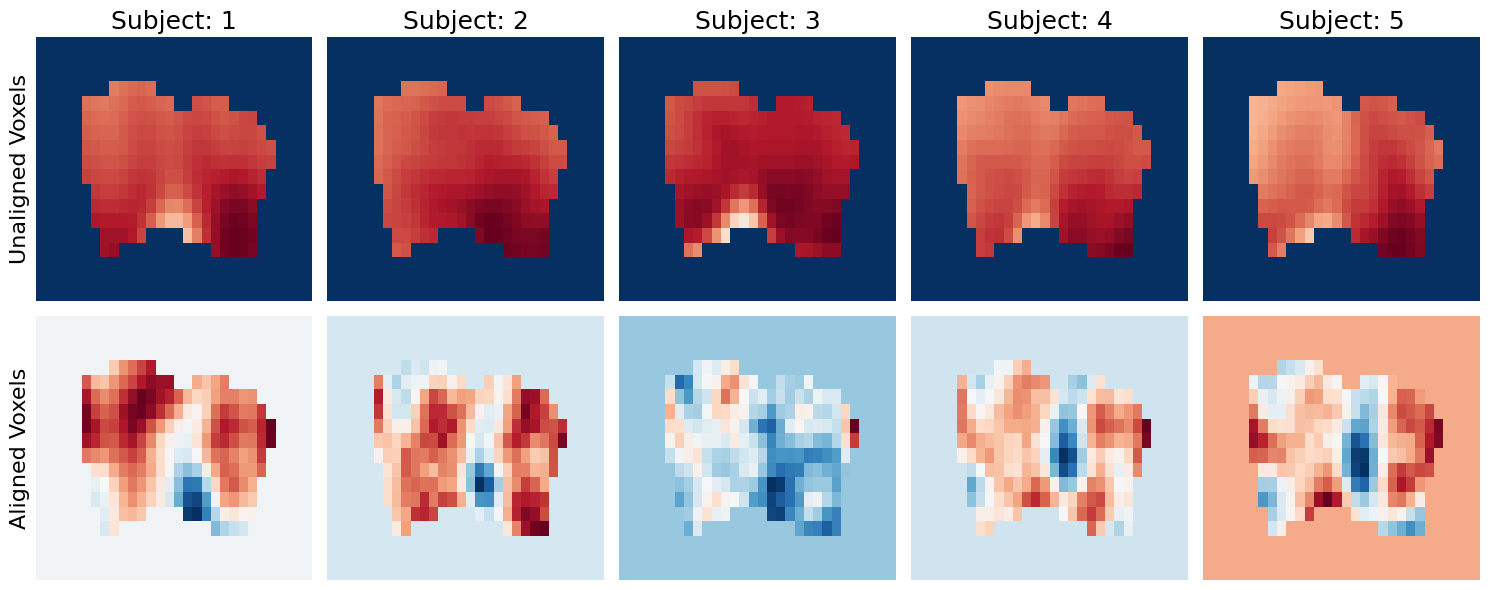

In [33]:
tr_index = 100

f,a = plt.subplots(ncols=5, nrows=2, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    sns.heatmap(np.rot90(ana_data[i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[0,i])
    a[0,i].set_title(f'Subject: {i+1}', fontsize=18)
    a[0,i].axes.get_xaxis().set_visible(False)
    a[0,i].yaxis.set_ticks([])
    sns.heatmap(np.rot90(hyperalign['transformed'][i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[1,i])
    a[1,i].axes.get_xaxis().set_visible(False)
    a[1,i].yaxis.set_ticks([])

a[0,0].set_ylabel('Unaligned Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Voxels', fontsize=16)

plt.tight_layout()

In [ ]:
data_dir = '/data/rainville/Hypnosis_ISC/4D_data/segmented'